In [36]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

local_file_path = './results/'
file_name = 'result_emnist_rounds_20_clients_12_selected_10.txt'
local = False  # Set to true if you want to use the already existing pickle files and not download from Minio

if not os.path.exists("plots"):
    os.mkdir("plots")


def read_server_values(data):
    values = []
    for line in data:
        # Splitting the line by ': ' and ', ' to extract values
        parts = line.split(", ")
        round_number = int(parts[0])
        accuracy = float(parts[1])
        accumulated_time = float(parts[2])

        # Adding the values to the list as a dictionary
        values.append({'round': round_number, 'accuracy': accuracy, 'accumulated_time': accumulated_time})

    return values


def read_client_values(data):
    values = []
    for line in data:
        print(line)
        # Splitting the line by ', ' to extract values
        parts = line.split(", ")
        round_number = int(parts[0])
        avg_accuracy = float(parts[1])
        avg_time = float(parts[2])

        # Adding the values to the list as a dictionary
        values.append({'round': round_number, 'avg_accuracy': avg_accuracy, 'avg_time': avg_time})

    return values


def read_file(local_file_path, file_name):
    server_data = []
    client_data = []
    with open(os.path.join(local_file_path, file_name), 'r') as file:
        print(f'Reading file {file_name}')
        data = file.readlines()

    reading_server_data = False
    reading_client_data = False

    for line in data:
        if 'Server values' in line:
            reading_server_data = True
            reading_client_data = False
            continue
        elif 'Average client values' in line:
            reading_client_data = True
            reading_server_data = False
            continue

        # If line doesn't start with a number, it is not a data line
        if not line.strip() or not line.strip()[0].isdigit():
            continue

        if reading_server_data:
            server_data.append(line.strip())
            continue
        if reading_client_data:
            client_data.append(line.strip())
            continue

    return read_server_values(server_data), read_client_values(client_data)


server_values, client_values = read_file(local_file_path, file_name)

print("Server values:")
print(server_values)

print("Client values:")
print(client_values)


Reading file result_emnist_rounds_20_clients_12_selected_10.txt
0, 0.2904861111111111, 9.805
1, 0.28725694444444444, 8.306666666666667
2, 0.3408333333333333, 8.912500000000001
3, 0.38204861111111105, 8.9425
4, 0.4532986111111111, 9.255
5, 0.491423611111111, 9.304999999999998
6, 0.5346180555555556, 9.361666666666666
7, 0.5903819444444445, 8.085833333333333
8, 0.6830208333333334, 9.315
9, 0.7597222222222221, 9.108333333333334
10, 0.8405208333333333, 9.526666666666666
11, 0.8785416666666667, 9.489166666666668
12, 0.9258680555555556, 9.415000000000001
13, 0.9322569444444445, 8.859166666666667
14, 0.9615277777777779, 9.2225
15, 0.9755555555555556, 9.514166666666666
16, 0.9739930555555557, 9.264166666666666
17, 0.9704166666666668, 9.506666666666666
18, 0.9772916666666666, 8.0425
19, 0.9775347222222223, 8.610833333333334
Server values:
[{'round': 1, 'accuracy': 0.2709, 'accumulated_time': 10.452300786972046}, {'round': 2, 'accuracy': 0.28025, 'accumulated_time': 19.80099368095398}, {'round': 

In [37]:
rounds = len(server_values)
clients = int(file_name.split('clients_')[1][0])
selected = int(file_name.split('selected_')[1][0])
train_round_durations_clients = []
train_accuracies = []
for client_value in client_values:
    train_round_durations_clients.append(client_value['avg_time'])
    train_accuracies.append(client_value['avg_accuracy'])
train_round_durations_clients = np.array(train_round_durations_clients)
train_accuracies = np.array(train_accuracies)

test_accuracies = []
training_time_server = []
for server_value in server_values:
    test_accuracies.append(server_value['accuracy'])
    if len(training_time_server) == 0:
        training_time_server.append(server_value['accumulated_time'])
        last_server_time = server_value['accumulated_time']
    else:
        training_time_server.append(server_value['accumulated_time'] - last_server_time)
        last_server_time = server_value['accumulated_time']

test_accuracies = np.array(test_accuracies)
training_time = server_values[-1]['accumulated_time']
# timed_out = content['timed_out']
training_time_server = np.array(training_time_server)
best_accuracy = test_accuracies[-1]

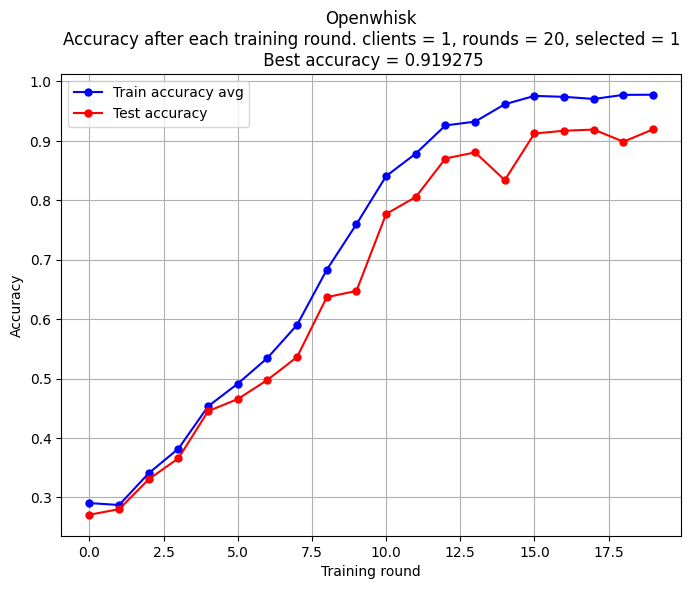

In [38]:
# Create sample data for two line plots
x = np.arange(len(train_accuracies))
y1 = train_accuracies
y2 = test_accuracies
# Create the first line plot with dots
plt.figure(figsize=(8, 6))

plt.plot(x, y1, label='Train accuracy avg', linestyle='-', marker='o', markersize=5, color='blue')

# Create the second line plot with dots
plt.plot(x, y2, label='Test accuracy', linestyle='-', marker='o', markersize=5, color='red')

# Add labels and a legend
plt.xlabel('Training round')
plt.ylabel('Accuracy')
plt.title(
    f'Openwhisk\nAccuracy after each training round. clients = {clients}, rounds = {rounds}, selected = {selected}\n Best accuracy = {test_accuracies.max()}')

plt.legend()

# Show the plot
plt.grid(True)
#plt.show()
plt.savefig(f'./plots/accuracies_c{clients}r{rounds}s{selected}', dpi=300)

In [39]:
limit = clients * rounds

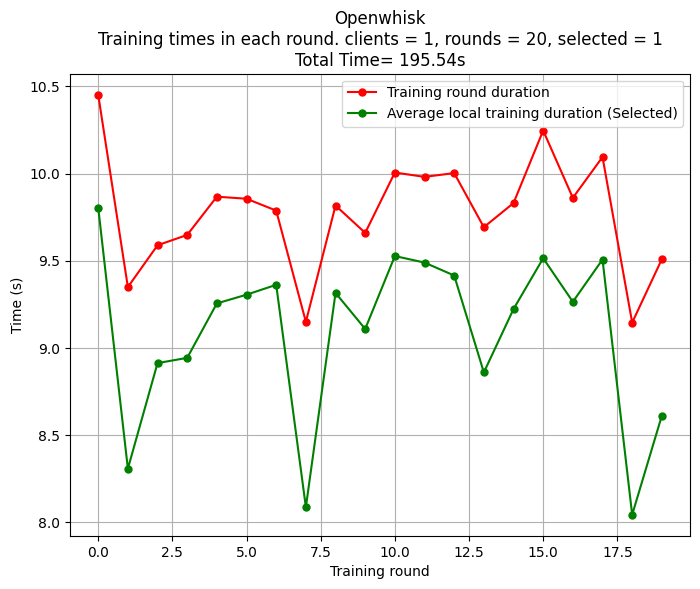

In [40]:
# Create sample data for two line plots
x = np.arange(len(train_accuracies))
y1 = training_time_server
y2 = train_round_durations_clients
# Create the first line plot with dots
plt.figure(figsize=(8, 6))

# Create the second line plot with dots
plt.plot(x, y1, label='Training round duration', linestyle='-', marker='o', markersize=5, color='red')

plt.plot(x, y2, label='Average local training duration (Selected)', linestyle='-', marker='o', markersize=5,
         color='green')

# Add labels and a legend
plt.xlabel('Training round')
plt.ylabel('Time (s)')
plt.title(
    f'Openwhisk\nTraining times in each round. clients = {clients}, rounds = {rounds}, selected = {selected}\nTotal Time= {np.round(training_time, 2)}s')

plt.legend()

# Show the plot
plt.grid(True)
#plt.show()
plt.savefig(f'./plots/time_c{clients}r{rounds}s{selected}', dpi=300)